In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals
%matplotlib inline
from matplotlib import pyplot
import caffe2
import numpy as np
import os
import shutil
import operator
import caffe2.python.predictor.predictor_exporter as pe
import os
import cv2
import random
import lmdb

from caffe2.python import core, utils, workspace
from caffe2.proto import caffe2_pb2

from caffe2.python import (
    brew,
    core,
    model_helper,
    net_drawer,
    optimizer,
    visualize,
    workspace,
)

# If you would like to see some really detailed initializations,
# you can change --caffe2_log_level=0 to --caffe2_log_level=-1
core.GlobalInit(['caffe2', '--caffe2_log_level=0'])
print("Necessities imported!")

Necessities imported!


In [2]:
def generateSequence(index,seqSize,noisyDatPath,refDatPath):
    noisySeq = []
    refSeq = []
    imgList = os.listdir(noisyDatPath)
    imgList.sort()
   
    if((index+seqSize)>len(imgList)):
        seqSize = len(imgList) - index
  
    for i in range(seqSize):
        noisyImg = cv2.imread(noisyDatPath+"//"+imgList[index+i])
        refImg   = cv2.imread(refDatPath+"//"+imgList[index+i])
        #noisyImg = cv2.imread(noisyDatPath+"//"+imgList[index+i])
        #refImg   = cv2.imread(refDatPath+"//"+imgList[index+i])
        noisySeq.append(noisyImg)
        refSeq.append(refImg)
    
        
    return noisySeq,refSeq
    
    

In [3]:
def generateSubseqence(srcNoisyImg,srcRefImg,seqSize,subSeqSize):
    
    noisySubSeq = []
    refSubSeq = []
    subSeqWindow = 32 #trying to create subimages of size 32x32, paper works with 128x128

    width,height = noisySeq[0].shape[0],noisySeq[0].shape[1]
    
    for k in range(subSeqSize):
        initW = random.randint(0,width-subSeqWindow-1)
        initH = random.randint(0,height-subSeqWindow-1)
        for i in range(seqSize):
            if(i>len(srcNoisyImg)-1):
                break
            subImageNoisy = srcNoisyImg[i][initW:initW+subSeqWindow,initH:initH+subSeqWindow,:3]
            subImageRef   = srcRefImg[i][initW:initW+subSeqWindow,initH:initH+subSeqWindow,:3]
            wN,hN = subImageRef.shape[0],subImageRef.shape[1]
            if((wN != subSeqWindow) or(hN != subSeqWindow)):
                print("width or height does not match:"+str(wN)+"x"+str(hN)+" initW:"+str(initW)+":"+str(initW+subSeqWindow)+" initH:"+str(initH)+":"+str(initH+subSeqWindow))
            noisySubSeq.append(subImageNoisy)
            refSubSeq.append(subImageRef)
        
    return noisySubSeq,refSubSeq
    

In [4]:
def showImage(img):
    pyplot.figure()
    pyplot.subplot(1,2,1)
    pyplot.imshow(img)
    pyplot.axis('on')
    pyplot.title('Original image = RGB')

In [5]:
def write_db(db_type, db_name, imgSeq, refSeq):
    db = core.C.create_db(db_type, db_name, core.C.Mode.write)
    transaction = db.new_transaction()
    for i in range(len(imgSeq)):
        feature_and_label = caffe2_pb2.TensorProtos()
        feature_and_label.protos.extend([
            utils.NumpyArrayToCaffe2Tensor(imgSeq[i]),
            utils.NumpyArrayToCaffe2Tensor(refSeq[i])])
        transaction.put(
            'train_%03d'.format(i),
            feature_and_label.SerializeToString())
    # Close the transaction, and then close the db.
    del transaction
    del db

In [6]:
noisyTraining = "//home//rohit//Rohit//Internship//caffe//projects//ML_TAA//data//trainingData//Noisy"
refTraining = "//home//rohit//Rohit//Internship//caffe//projects//ML_TAA//data//trainingData//Ref"

i = 0
if(len(os.listdir(noisyTraining)) !=  len(os.listdir(refTraining))):
    print("Error: Training and ref sizes match!")

dirSize = len(os.listdir(noisyTraining))
seqSize = 7
subSeqSize = 500
totalNoisyImage = []
totalRefImage = []

while(i < dirSize):
    noisySeq,refSeq = generateSequence(i,seqSize,noisyTraining,refTraining)
    noisySubSeq,refSubSeq = generateSubseqence(noisySeq,refSeq,seqSize,subSeqSize)
    totalNoisyImage.extend(noisySubSeq)
    totalRefImage.extend(refSubSeq)

    '''if i == 0:
        for k in range(len(noisySubSeq)):
            showImage(noisySubSeq[k])
            showImage(refSubSeq[k])'''
    i+=seqSize

write_db("minidb", "//home//rohit//Rohit//Internship//TAA_ML//ML_TAA.minidb", totalNoisyImage,totalRefImage)
seqSize = 1

In [40]:
def AddInput(model, batch_size, db, db_type):
    noisyImg_uint8,refImg_uint8 = model.TensorProtosDBInput([], ["noisyImg_uint8", "refImg_uint8"], batch_size=batch_size,
        db=db, db_type=db_type)
    
    noisyImg = model.Cast(noisyImg_uint8, "noisyImg", to=core.DataType.FLOAT)
    # scale data from [0,255] down to [0,1]
    noisyImg = model.Scale(noisyImg, noisyImg, scale=float(1./256))
    noisyImg = model.NHWC2NCHW(noisyImg,"noisyImgNCHW")
    # don't need the gradient for the backward pass
    noisyImg = model.StopGradient(noisyImg, noisyImg)
    
    
    refImg = model.Cast(refImg_uint8, "refImg", to=core.DataType.FLOAT)
    # scale data from [0,255] down to [0,1]
    refImg = model.Scale(refImg, refImg, scale=float(1./256))
    refImg = model.NHWC2NCHW(refImg,"refImgNCHW")
    # don't need the gradient for the backward pass
    refImg = model.StopGradient(refImg, refImg)
    
    return noisyImg, refImg
    

In [41]:
CONV_KERNEL_SIZE  = 3

CONV_KERNEL_PADING1 = 1
CONV_KERNEL_STRIDE1 = 1

CONV_KERNEL_PADING2 = 4
CONV_KERNEL_STRIDE2 = 3

def AddRecurrentBlock(model,data,layerNo,hiddenLayer,W,U,bias,filter_count_in,filter_count_out):
    #convR1 = brew.conv(model, data, 'conv1', dim_in=3, dim_out=20, kernel=3,pad_t=1,pad_l=4,pad_r=4,pad_b=1,stride = 1)
   
    convR1 = brew.conv(model,data,"convR1"+str(layerNo),dim_in=filter_count_in,dim_out=filter_count_out,
                       kernel=CONV_KERNEL_SIZE,stride = CONV_KERNEL_STRIDE1,pad = CONV_KERNEL_PADING1)
    
    '''conCatR1,conCatDimsR1 = model.net.Concat( [convR1, hiddenLayer],['concatR1'+str(layerNo), 'conCatDimsR1'+str(layerNo)], axis=3)
    convR2 = brew.conv(model,conCatR1,"convR2"+str(layerNo),dim_in=filter_count_out,dim_out=filter_count_out,
                       kernel=3,
                       pad_t = 1,
                       pad_b = 1,
                       pad_l = 0,
                       pad_r = 1,
                       stride_w = 2,
                       stride_h = 1)'''
    
    temp1 = model.net.BatchMatMul([hiddenLayer,W],"temp1"+str(layerNo))
    temp2 = model.net.BatchMatMul([convR1,U],"temp2"+str(layerNo))
    convR2 = model.net.Add([temp1,temp2],"convR2"+str(layerNo))

    convR3 = brew.conv(model,convR2,"convR3"+str(layerNo),dim_in=filter_count_out,dim_out=filter_count_out,
                       kernel=CONV_KERNEL_SIZE,stride = CONV_KERNEL_STRIDE1,pad = CONV_KERNEL_PADING1)
    hiddenLayer = convR3
    
    return convR3

In [42]:
def AddEncoderDecoder(model, noisyData):
    
    #creating recurrent hidden layers
    hidden1 = train_model.param_init_net.XavierFill([], 'hidden1', shape=[seqSize,8,32,32])
    weights1 = train_model.param_init_net.XavierFill([], 'weights1', shape=[seqSize,8,32,32])
    hweights1 = train_model.param_init_net.XavierFill([], 'hweights1', shape=[seqSize,8,32,32])
    bias1 = train_model.param_init_net.XavierFill([], 'bias1', shape=[seqSize,8,32,32])
    
    hidden2 = train_model.param_init_net.XavierFill([], 'hidden2', shape=[seqSize,16,16,16])
    weights2 = train_model.param_init_net.XavierFill([], 'weights2', shape=[seqSize,16,16,16])
    hweights2 = train_model.param_init_net.XavierFill([], 'hweights2', shape=[seqSize,16,16,16])
    bias2 = train_model.param_init_net.XavierFill([], 'bias2', shape=[seqSize,16,16,16])
    
    hidden3 = train_model.param_init_net.XavierFill([], 'hidden3', shape=[seqSize,32,8,8])
    weights3 = train_model.param_init_net.XavierFill([], 'weights3', shape=[seqSize,32,8,8])
    hweights3 = train_model.param_init_net.XavierFill([], 'hweights3', shape=[seqSize,32,8,8])
    bias3 = train_model.param_init_net.XavierFill([], 'bias3', shape=[seqSize,32,8,8])
    
    hidden4 = train_model.param_init_net.XavierFill([], 'hidden4', shape=[seqSize,64,4,4])
    weights4 = train_model.param_init_net.XavierFill([], 'weights4', shape=[seqSize,64,4,4])
    hweights4 = train_model.param_init_net.XavierFill([], 'hweights4', shape=[seqSize,64,4,4])
    bias4 = train_model.param_init_net.XavierFill([], 'bias4', shape=[seqSize,64,4,4])
    
    #ENCODER PART
    # Image size: 32 x 32 -> 32 x 32
    conv1 = AddRecurrentBlock(model,noisyData,1,hidden1,hweights1,weights1,bias1,3,8)
    # Image size: 32 x 32 -> 16 x 16
    pool1 = brew.max_pool(model, conv1, 'pool1', kernel = 2, stride = 2)

    # Image size: 16 x 16 -> 16 x 16
    conv2 = AddRecurrentBlock(model,pool1,2,hidden2,hweights2,weights2,bias2,8,16)
    # Image size: 8x8 -> 8x8
    pool2 = brew.max_pool(model, conv2, 'pool2', kernel=2, stride=2)
    
    # Image size: 8x8 -> 8 x 8
    conv3 = AddRecurrentBlock(model,pool2,3,hidden3,hweights3,weights3,bias3,16,32)
    # Image size: 8x8 -> 4x4
    pool3 = brew.max_pool(model, conv3, 'pool3', kernel=2, stride=2)
    
    # Image size: 4x4 -> 4x4
    conv4 = AddRecurrentBlock(model,pool3,4,hidden4,hweights4,weights4,bias4,32,64)
    
    ###DECODER PART
    
    upconv3 = brew.conv_transpose(model, conv4, "upcon3", dim_in=64, dim_out=32, kernel=3, pad=1)
    upsample3 = brew.conv_transpose(model, upconv3, "upsample3", dim_in=32, dim_out=32, kernel=2, stride=2)
    conCatD3 = model.net.Add( [upsample3, conv3], ['concatD3'])
    convD3 = brew.conv(model,conCatD3,"convD3",dim_in=32,dim_out=32,kernel = 3, stride = CONV_KERNEL_STRIDE1,pad = CONV_KERNEL_PADING1)
    '''conCatD3,conCatDimsD3 = model.net.Concat( [upsample3, conv3], ['concatD3', 'conCatDimsD3'], axis=2)
    convD3 = brew.conv(model,conCatD3,"convD3",dim_in=32,dim_out=32,
                       kernel=3,
                       pad_t = 1,
                       pad_b = 1,
                       pad_l = 0,
                       pad_r = 1,
                       stride_w = 2,
                       stride_h = 1)'''
    
    leakyReluD3 = model.net.LeakyRelu(convD3,['leakyReluD3'])
    
    upconv2 = brew.conv_transpose(model, leakyReluD3, "upcon2", dim_in=32, dim_out=16, kernel=3, pad=1)
    upsample2 = brew.conv_transpose(model, upconv2, "upsample2", dim_in=16, dim_out=16, kernel=2, stride=2)
    '''conCatD2,conCatDimsD2 = model.net.Concat( [upsample2, conv2], ['concatD2', 'conCatDimsD2'], axis=2)
    convD2 = brew.conv(model,conCatD2,"convD2",dim_in=16,dim_out=16,kernel=3,
                       pad_t = 1,
                       pad_b = 1,
                       pad_l = 0,
                       pad_r = 1,
                       stride_w = 2,
                       stride_h = 1)'''
    conCatD2= model.net.Add( [upsample2, conv2], ['concatD2'])
    convD2 = brew.conv(model,conCatD2,"convD",dim_in=16,dim_out=16,kernel = 3, stride = CONV_KERNEL_STRIDE1,pad = CONV_KERNEL_PADING1)
    leakyReluD2 = model.net.LeakyRelu(convD2,['leakyReluD2'])
    
    upconv1 = brew.conv_transpose(model, leakyReluD2, "upcon1", dim_in=16, dim_out=8, kernel=3, pad=1)
    upsample1 = brew.conv_transpose(model, upconv1, "upsample1", dim_in=8, dim_out=8, kernel=2, stride=2)
    '''conCatD1,conCatDimsD1 = model.net.Concat( [upsample1, conv1], ['concatD1', 'conCatDimsD1'], axis=2)
    convD1 = brew.conv(model,conCatD1,"convD1",dim_in=8,dim_out=3,kernel=3,
                       pad_t = 1,
                       pad_b = 1,
                       pad_l = 0,
                       pad_r = 1,
                       stride_w = 2,
                       stride_h = 1)'''
    conCatD1 = model.net.Add( [upsample1, conv1], ['concatD1'])
    convD1 = brew.conv(model,conCatD1,"convD1",dim_in=8,dim_out=8,kernel = 3, stride = CONV_KERNEL_STRIDE1,pad = CONV_KERNEL_PADING1)
    convD1 = model.net.LeakyRelu(convD1,['leakyReluD1'])
    
    convDout = brew.conv(model,conCatD1,"convDout",dim_in=8,dim_out=3,kernel = 3, stride = CONV_KERNEL_STRIDE1,pad = CONV_KERNEL_PADING1)
    convDoutNHWC = model.net.NCHW2NHWC([convDout],["convDoutNHWC"])
    return convDout

In [43]:
def addLosses(model,genImg,refImg):
    ws = 0.8
    wg = 0.1
    wt = 0.1
    #Add Spatial Loss]
    dist = model.net.L1Distance([genImg,refImg],"dist")
    Ls = model.AveragedLoss(dist, "loss")
    #Ls = model.Scale(Ls, Ls, scale=ws)
    #Add Gradient Loss
    Lg = 0
    #Add Temporal Loss
    Lt = 0
    
    return (Ls)

In [44]:
arg_scope = {"order": "NCHW"}
# Create the model helper for the train model
train_model = model_helper.ModelHelper(name="mnist_train", arg_scope=arg_scope)

# Specify the input is from the train lmdb
noisyImg, refImg = AddInput(
    train_model, batch_size=seqSize,
    db = "//home//rohit//Rohit//Internship//TAA_ML//ML_TAA.minidb",
    db_type = "minidb")

genImg = AddEncoderDecoder(train_model,noisyImg)
Loss = addLosses(train_model,genImg,refImg)
train_model.AddGradientOperators([Loss])
optimizer.build_adam(train_model, base_learning_rate=0.0001)

workspace.RunNetOnce(train_model.param_init_net)
workspace.CreateNet(train_model.net, overwrite=True)
workspace.RunNet(train_model.Proto().name)


True

In [45]:
total_iters = len(totalNoisyImage)
loss = np.zeros(total_iters)
for i in range(total_iters):
    workspace.RunNet(train_model.Proto().name)
    loss[i] = workspace.blobs['loss']
    if(i%1000 == 0):
        print("Iter: {}, Loss: {}".format(i,loss[i]))



Iter: 0, Loss: 894.55615234375
Iter: 1000, Loss: 645.12548828125
Iter: 2000, Loss: 389.4385986328125
Iter: 3000, Loss: 127.84733581542969
Iter: 4000, Loss: 91.4124755859375
Iter: 5000, Loss: 395.4208984375
Iter: 6000, Loss: 493.03497314453125
Iter: 7000, Loss: 222.97943115234375
Iter: 8000, Loss: 50.30958557128906
Iter: 9000, Loss: 126.53811645507812
Iter: 10000, Loss: 458.9710998535156
Iter: 11000, Loss: 95.04107666015625
Iter: 12000, Loss: 504.36962890625
Iter: 13000, Loss: 306.7667236328125
Iter: 14000, Loss: 404.46087646484375
Iter: 15000, Loss: 457.47467041015625
Iter: 16000, Loss: 76.35406494140625
Iter: 17000, Loss: 865.3480834960938
Iter: 18000, Loss: 396.2046203613281
Iter: 19000, Loss: 64.45962524414062
Iter: 20000, Loss: 82.37894439697266
Iter: 21000, Loss: 408.3830871582031
Iter: 22000, Loss: 189.650390625
Iter: 23000, Loss: 366.426025390625
Iter: 24000, Loss: 307.96783447265625
Iter: 25000, Loss: 395.2755126953125
Iter: 26000, Loss: 495.69390869140625
Iter: 27000, Loss: 17

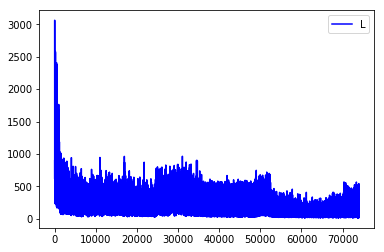

In [46]:
pyplot.plot(loss, 'b')
pyplot.legend(('Loss'), loc='upper right')

(1, 32, 32, 3)
(1, 32, 32, 3)
(1, 32, 32, 3)


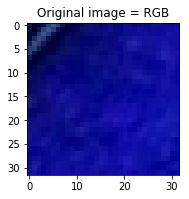

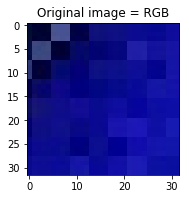

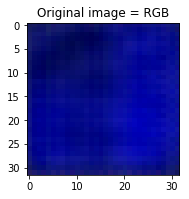

In [79]:

workspace.RunNet(train_model.Proto().name)
genImg = workspace.FetchBlob('convDoutNHWC')

noisyImage = workspace.FetchBlob('noisyImg')
refImage = workspace.FetchBlob('refImg')
print(genImg.shape)
print(noisyImage.shape)
print(refImage.shape)

tempImage = genImg.copy()
tempImage[tempImage < 0] = 0

showImage(refImage[0])
showImage(noisyImage[0])
showImage(tempImage[0])